# Generates the accuracy overlay figure (fig. 4) seen in paper

In [1]:
#importing things, Preventing divide by zero.

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
def myfft2(A): 
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A)))
def myifft2(A): 
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(A)))
from skimage.metrics import structural_similarity as ssim
eps = np.finfo(float).eps
import tensorflow as tf
from scipy import optimize
from tensorflow.keras import optimizers as kopt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras

In [2]:
data=np.load('curated_data/speckle_datasets.npy')

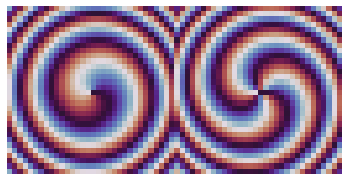

In [3]:
# Topological Charges
m1 = 1 ; m2 = 3

xmax = 10       # f-plane max
dim = 32        # Image Size
dx = 2*xmax/dim # f-plane pixel size

# Get cylindrical coord
x = np.linspace(-xmax,xmax-dx,dim)
X,Y=np.meshgrid(x,x)
R2=(X**2+Y**2)
T = np.arctan2(Y,X)

# Lens Parameters
flambda=80
Lens = np.exp(-1j*R2/(flambda/10))

# Vortex phase modulation
V1 = np.exp(1j*(m1)*T) 
V2 = np.exp(1j*(m2)*T)
LG1=Lens*V1 ; LG2=Lens*V2

# Plot phase to make sure it's the right shape
plt.imshow(np.angle(np.hstack((LG1,LG2))),cmap='twilight')
plt.axis('off')
plt.show()

# This function takes a numpy array of size [num_images, dim, dim]
# and applies a vortex phase, an fft, and an absolute value to each image
def vort_THIS(A,LGA,LGB):
    length=A.shape[0]
    out=np.zeros((length,A.shape[1],A.shape[2]*2))
    for i in range(length):
        A1=np.abs(myfft2(np.exp(1j*A[i]*np.pi/2)*LGA)) ; A2=np.abs(myfft2(np.exp(1j*A[i]*np.pi/2)*LGB))
        # Our single layer NN requires domain restriction within [-1,1]
        A1=(A1-np.amin(A1))/np.amax(A1-np.amin(A1))*2-1    ; A2=(A2-np.amin(A2))/np.amax(A2-np.amin(A2))*2-1
        out[i]=np.hstack((A1,A2))
    return out

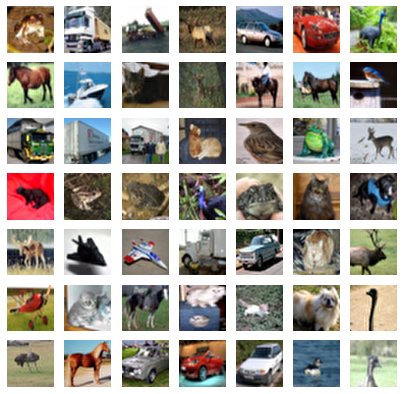

In [3]:
# Loads CiFAR images from zip availible from toronto.edu
# This can be loaded from keras instead

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

di = unpickle('cifar-10-batches-py/data_batch_1')

di = unpickle('cifar-10-batches-py/data_batch_1')
imageA = di[b'data']
dim = 32
dims = dim**2
Imarray = np.zeros([dims, 3072])
for ii in range(dims):
    Imarray[ii,:] = imageA[ii]
def myplot7x7rgb(R, G, B):
    fig, axes = plt.subplots(7, 7, figsize=(7,7))
    for ii in range(49):
        i = (ii//7)
        j = np.mod(ii, 7)
        im = axes[i,j].imshow(np.dstack((R[ii,:,:]/255,G[ii,:,:]/255,B[ii,:,:]/255)), cmap = 'gray',
                              interpolation='sinc')
            #plt.colorbar(im, ax=axes[i,j])    
        axes[i,j].set_aspect('equal')
#            axes[i,j].set_title('dx='+ str(j) + ', dy='+ str(i), fontsize=12)
        axes[i,j].set_axis_off()
Rs = np.zeros([32*32, 32, 32])
Gs = np.zeros([32*32, 32, 32])
Bs = np.zeros([32*32, 32, 32])

for ii in range(Imarray.shape[0]):
    test = Imarray[ii].reshape([3,32,32])
    Rs[ii, :, :] = test[0]
    Gs[ii, :, :] = test[1]
    Bs[ii, :, :] = test[2]
    
myplot7x7rgb(Rs, Gs, Bs)
imss=np.zeros((32**2,32,32,3))
mono_test=np.zeros((32**2,32,32))
for i in range(32**2):
    imss[i,:,:,0]=Rs[i]/255
    imss[i,:,:,1]=Gs[i]/255
    imss[i,:,:,2]=Bs[i]/255
    mono_test[i] = Rs[i]/255*0.299 + Gs[i]/255*0.587 + Bs[i]/255*0.114 #linear approximation of perceptual luminance and color gamma corrcted. Source: https://e2eml.school/convert_rgb_to_grayscale.html

# Loads MNIST datasets
(_,_),(num,_)=tf.keras.datasets.mnist.load_data()
(_,_),(fas,_)=tf.keras.datasets.fashion_mnist.load_data()
num=num/255; fas=fas/255

In [ ]:
# Creates a single layer linear NN with no bias
# ADAM has a learning rate of 0.01
# Assumes that the input is an image transformed by 2 masks and the output is the original untransformed image
def base_model():
    model = Sequential()
    model.add(Dense(dim**2, input_dim= 2*dim ** 2, activation='linear', use_bias=False))  
    model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
    return model

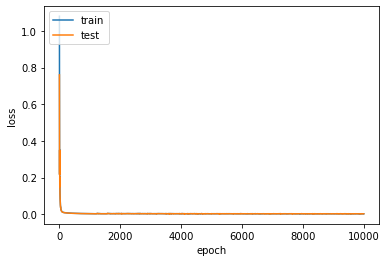

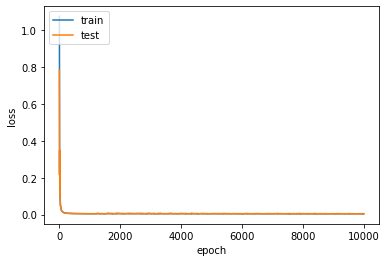

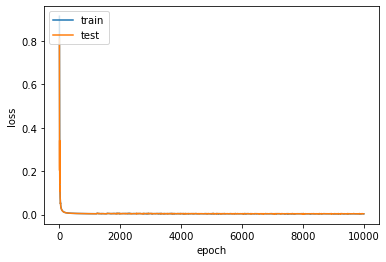

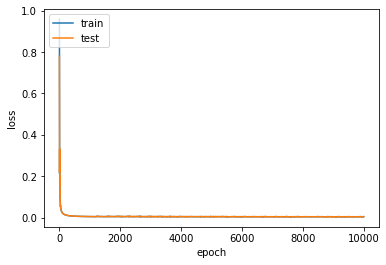

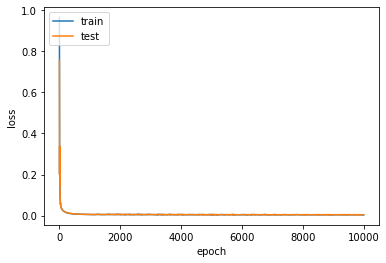

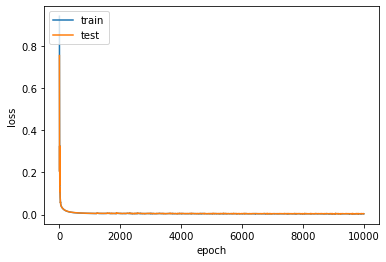

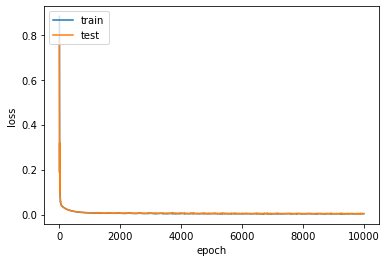

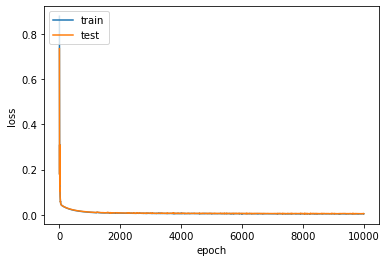

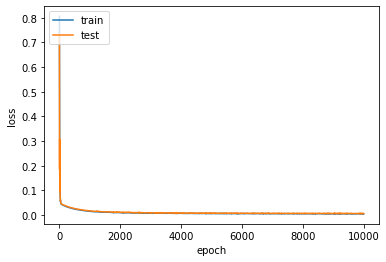

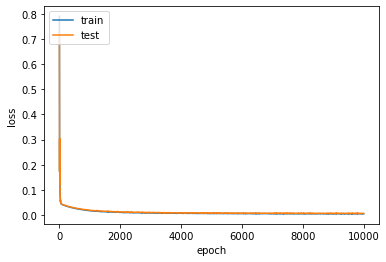

In [8]:
# Creates lists for all learned models
models=[[],[],[],[],[],[],[],[],[],[]]
histories=[[],[],[],[],[],[],[],[],[],[]]

#cycles through created datasets, fits models
for i in range(10):
    dataset=data[i]
    for j in range(10000):
        dataset[j]=dataset[j]/np.amax(dataset[j]) #make sure pretransformed images are [0,1]
    train=vort_THIS(dataset,LG1,LG2) #transform data
    y_lin=dataset.reshape(10000,32*32)
    x_lin=train.reshape(10000,32*32*2)
    amodel=base_model()
    models[i].append(amodel)
    # To save resources, this should save callbacks to test for convergence,
    # but we also want to look at learning rate 
    history=models[i][0].fit(x_lin, y_lin, validation_split=0.01,shuffle = True, verbose = 0, batch_size = 784*60,epochs=10000)
    histories[i].append(history)
    plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
    plt.ylabel('loss'); plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
# Function to calculate H_{SVD}

import numpy.linalg as la
eps = np.finfo(float).eps
def my_svdn(xx):
    u, s, v = la.svd(xx)
    s = np.where(s==0, eps, s) # Replacing the zeros with 10^-15
    return np.sum(-(s/np.sum(s))*np.log2(s/np.sum(s)))/np.log2(xx.shape[0])

In [64]:
# Calculate structural similarity indices for reconstructed images
# and H_{SVD} for source images 

dataset_avgs=[]
dataset_stds=[]
for i in range(10):
    dataset_avgs.append(np.average(dataset_ssims[i]))
    dataset_stds.append(np.std(dataset_ssims[i]))
    
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
def find_ssims(x1,x2):
    length=np.shape(x1)[0]
    ss=[]
    for i in range(length):
        ss.append(ssim(x1[i],x2[i]))
    return ss
def find_mses(x1,x2):
    length=np.shape(x1)[0]
    ss=[]
    for i in range(length):
        ss.append(mean_squared_error(x1[i],x2[i]))
    return ss

dataset_ssims=[[],[],[],[],[],[],[],[],[],[]]
for i in range(10):
    for j in range(10000):
        dataset_ssims[i].append(my_svdn(np.exp(data[i,j]*1j*2*np.pi)*LG1))
        dataset_ssims[i].append(my_svdn(np.exp(data[i,j]*1j*2*np.pi)*LG2))
CiFAR_ssims=[]
for i in range(1024):
    CiFAR_ssims.append(my_svdn(np.exp(mono_test[i]*1j*2*np.pi)*LG1))
    CiFAR_ssims.append(my_svdn(np.exp(mono_test[i]*1j*2*np.pi)*LG2))
FASHION_ssims=[]
NUM_ssims=[]
fasn=np.zeros((10000,32,32))
numn=np.zeros((10000,32,32))
for i in range(10000):
    fasn[i,2:30,2:30]=fas[i]
    numn[i,2:30,2:30]=num[i]
    FASHION_ssims.append(my_svdn(np.exp(fasn[i]*1j*2*np.pi)*LG1))
    FASHION_ssims.append(my_svdn(np.exp(fasn[i]*1j*2*np.pi)*LG2))
    NUM_ssims.append(my_svdn(np.exp(numn[i]*1j*2*np.pi)*LG1))
    NUM_ssims.append(my_svdn(np.exp(numn[i]*1j*2*np.pi)*LG2))

In [26]:
# Calculates MSE and SSIM

fas_pred=np.zeros((10,10000,32,32))
num_pred=np.zeros((10,10000,32,32))
cif_pred=np.zeros((10,1024,32,32))
fas_ss=[[],[],[],[],[],[],[],[],[],[]]
num_ss=[[],[],[],[],[],[],[],[],[],[]]
cif_ss=[[],[],[],[],[],[],[],[],[],[]]
fas_ms=[[],[],[],[],[],[],[],[],[],[]]
num_ms=[[],[],[],[],[],[],[],[],[],[]]
cif_ms=[[],[],[],[],[],[],[],[],[],[]]

for i in range(10):
    fas_pred[i]=(models[i][0].predict(vort_THIS(fasn,LG1,LG2).reshape(10000,32*32*2))).reshape(10000,32,32)
    num_pred[i]=(models[i][0].predict(vort_THIS(numn,LG1,LG2).reshape(10000,32*32*2))).reshape(10000,32,32)
    cif_pred[i]=(models[i][0].predict(vort_THIS(mono_test,LG1,LG2).reshape(1024,32*32*2))).reshape(1024,32,32)
    fas_ss[i]=find_ssims(fas_pred[i],fasn)
    num_ss[i]=find_ssims(num_pred[i],numn)
    cif_ss[i]=find_ssims(cif_pred[i],mono_test)
    fas_ms[i]=find_mses(fas_pred[i],fasn)
    num_ms[i]=find_mses(num_pred[i],numn)
    cif_ms[i]=find_mses(cif_pred[i],mono_test)

In [66]:
fsn=[]
nsn=[]
csn=[]
for i in range(10000):
    fsn.append(np.average([FASHION_ssims[i*2],FASHION_ssims[i*2+1]]))
    nsn.append(np.average([NUM_ssims[i*2],NUM_ssims[i*2+1]]))
for i in range(1024):
    csn.append(np.average([CiFAR_ssims[2*i],CiFAR_ssims[2*i+1]]))

In [68]:
averages_sims_fas=[]
averages_sims_num=[]
averages_sims_cif=[]
averages_mses_fas=[]
averages_mses_num=[]
averages_mses_cif=[]
for i in range(10):
    averages_sims_fas.append(np.average(fas_ss[i]))
    averages_sims_num.append(np.average(num_ss[i]))
    averages_sims_cif.append(np.average(cif_ss[i]))
    averages_mses_fas.append(np.average(fas_ms[i]))
    averages_mses_num.append(np.average(num_ms[i]))
    averages_mses_cif.append(np.average(cif_ms[i]))

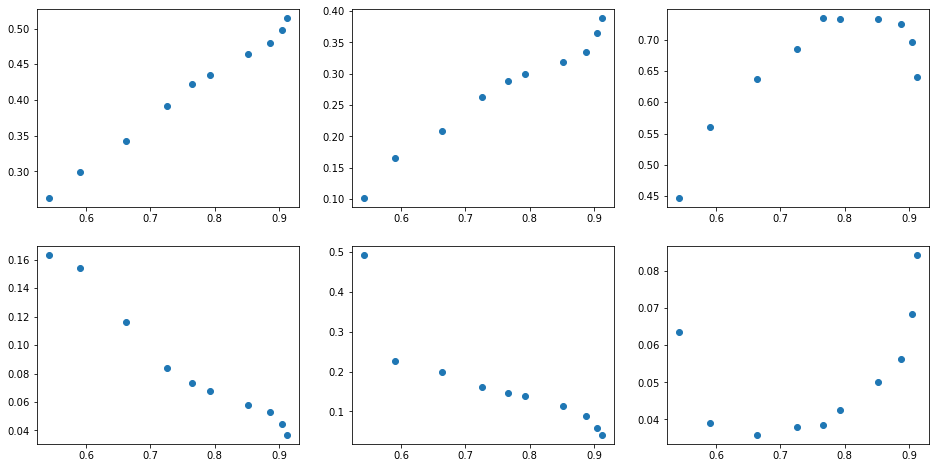

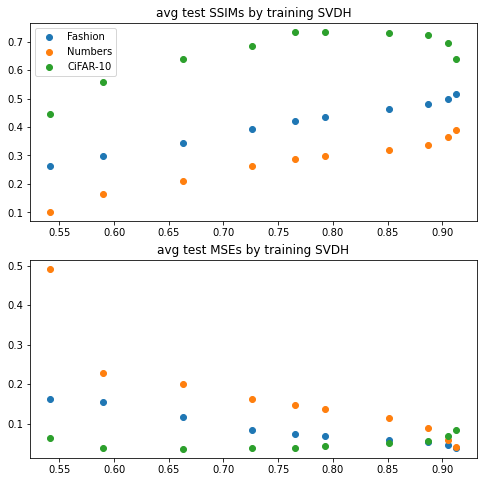

In [69]:
f,a=plt.subplots(2,3,figsize=(8*2,4*2))
f1,a1=plt.subplots(2,1,figsize=(4*2,4*2))
a[0,0].scatter(dataset_avgs,averages_sims_fas)
a[0,1].scatter(dataset_avgs,averages_sims_num)
a[0,2].scatter(dataset_avgs,averages_sims_cif)
a[1,0].scatter(dataset_avgs,averages_mses_fas)
a[1,1].scatter(dataset_avgs,averages_mses_num)
a[1,2].scatter(dataset_avgs,averages_mses_cif)
a1[0].scatter(dataset_avgs,averages_sims_fas,label='Fashion')
a1[0].scatter(dataset_avgs,averages_sims_num,label='Numbers')
a1[0].scatter(dataset_avgs,averages_sims_cif,label='CiFAR-10')
a1[0].set_title('avg test SSIMs by training SVDH')
a1[1].scatter(dataset_avgs,averages_mses_fas,label='Fashion')
a1[1].scatter(dataset_avgs,averages_mses_num,label='Numbers')
a1[1].scatter(dataset_avgs,averages_mses_cif,label='CiFAR-10')
a1[1].set_title('avg test MSEs by training SVDH')
a1[0].legend()
plt.show()

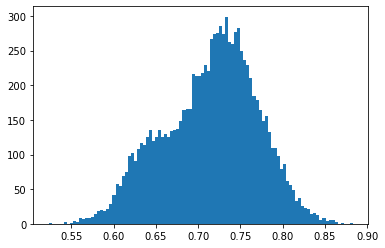

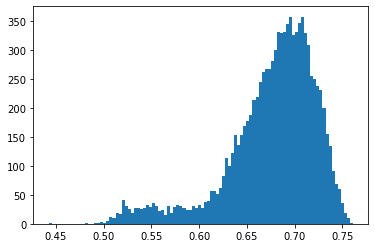

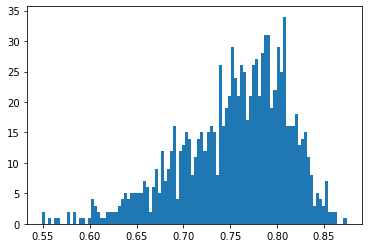

In [70]:
plt.hist(fsn,100)
plt.show()
plt.hist(nsn,100)
plt.show()
plt.hist(csn,100)
plt.show()

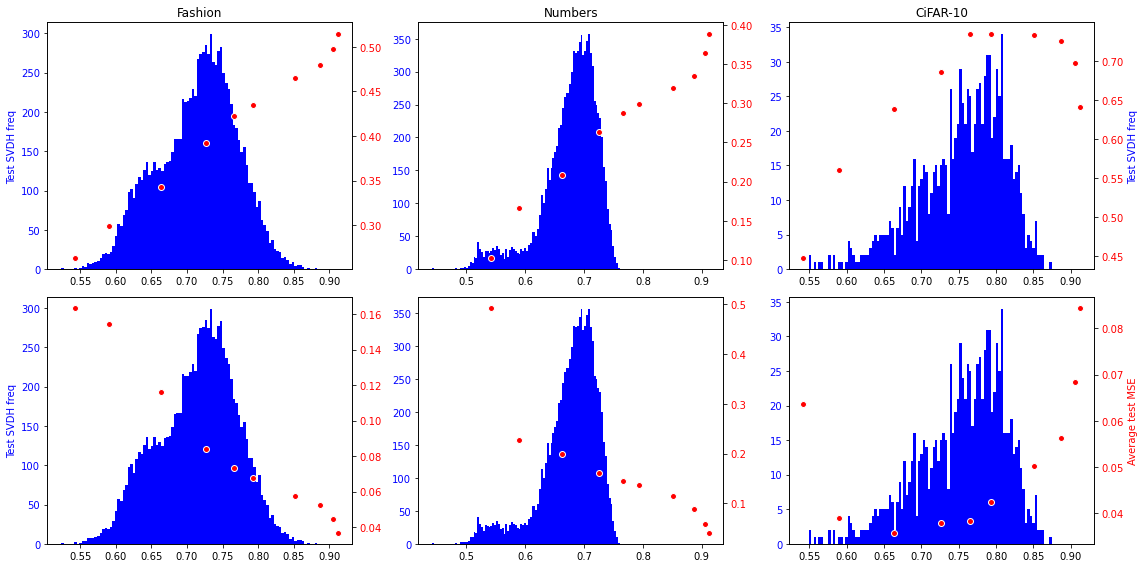

In [76]:
f,a1=plt.subplots(2,3,figsize=(8*2,4*2))
a2=a1[0,0].twinx()
a3=a1[0,1].twinx()
a4=a1[0,2].twinx()

a5=a1[1,0].twinx()
a6=a1[1,1].twinx()
a7=a1[1,2].twinx()
color1='blue'
color2='red'


a1[0,0].hist(fsn,100, color=color1)
a1[0,1].hist(nsn,100, color=color1)
a1[0,2].hist(csn,100, color=color1)
a1[1,0].hist(fsn,100, color=color1)
a1[1,1].hist(nsn,100, color=color1)
a1[1,2].hist(csn,100, color=color1)
a2.scatter(dataset_avgs,averages_sims_fas, color=color2,edgecolors='white')
a3.scatter(dataset_avgs,averages_sims_num, color=color2,edgecolors='white')
a4.scatter(dataset_avgs,averages_sims_cif, color=color2,edgecolors='white')
a5.scatter(dataset_avgs,averages_mses_fas, color=color2,edgecolors='white')
a6.scatter(dataset_avgs,averages_mses_num, color=color2,edgecolors='white')
a7.scatter(dataset_avgs,averages_mses_cif, color=color2,edgecolors='white')
a7.set_ylabel('Average test MSE',color=color2)
a4.set_ylabel('Test SVDH freq',color=color1)
a1[1,0].set_ylabel('Test SVDH freq',color=color1)
a1[0,0].set_ylabel('Test SVDH freq',color=color1)
a1[0,0].set_title('Fashion')
a1[0,1].set_title('Numbers')
a1[0,2].set_title('CiFAR-10')

for i in range(2):
    for j in range(3):
        a1[i,j].tick_params(axis='y',labelcolor=color1)
a2.tick_params(axis='y',labelcolor=color2)
a3.tick_params(axis='y',labelcolor=color2)
a4.tick_params(axis='y',labelcolor=color2)
a5.tick_params(axis='y',labelcolor=color2)
a6.tick_params(axis='y',labelcolor=color2)
a7.tick_params(axis='y',labelcolor=color2)
f.tight_layout()
plt.show()

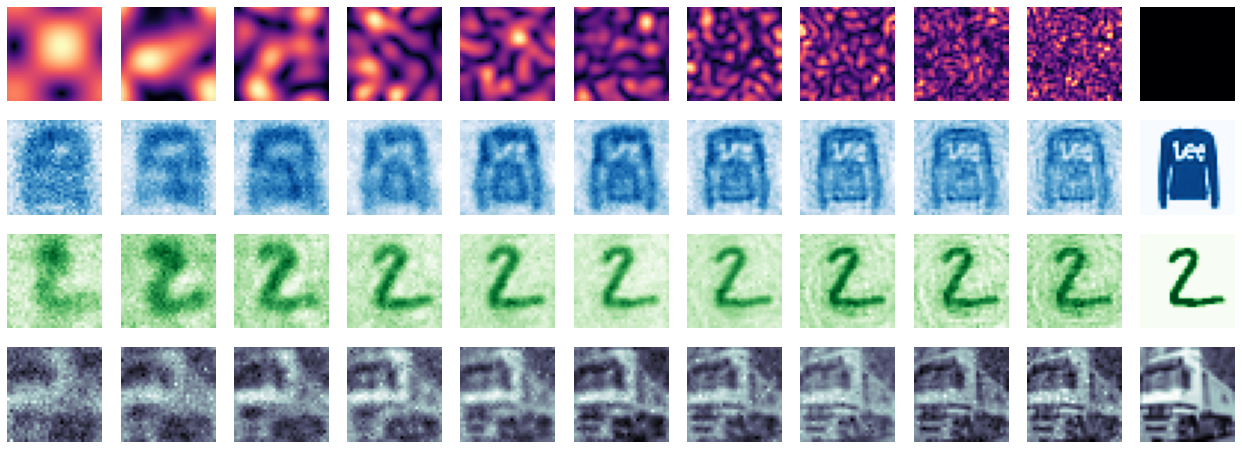

In [72]:
f,a=plt.subplots(4,11,figsize=(22,8))
for i in range(10):
    a[0,i].imshow(data[i,1],cmap='magma')
    a[0,i].axis('off')
    a[1,i].imshow(fas_pred[i,1],cmap='Blues')
    a[1,i].axis('off')
    a[2,i].imshow(num_pred[i,1],cmap='Greens')
    a[2,i].axis('off')
    a[3,i].imshow(cif_pred[i,1],cmap='bone')
    a[3,i].axis('off')
a[0,10].imshow(np.zeros((32,32)),cmap='magma')
a[1,10].imshow(fasn[1],cmap='Blues')
a[2,10].imshow(numn[1],cmap='Greens')
a[3,10].imshow(mono_test[1],cmap='bone')
a[0,10].axis('off')
a[1,10].axis('off')
a[2,10].axis('off')
a[3,10].axis('off')
plt.show()